# TP 3 Monotonie et limiteurs

**Objectif du TP**

L’objectif de ce TP est d’étudier l’action de limiteurs classiques sur les schémas de Beam-Warming et Lax-Wendroff.\
Pour chacun de ces schémas :

## 1 Schéma de BW

Pour rappel, le schéma de BW limité s’écrit :
$$
\begin{align*}
u_{i}^{n+1} \space &=  \space u_i ^{n} - \mathcal{C}(u_i^{n} - u_{i-1}^{n})\\
&\qquad -\frac{\mathcal{C}}{2}(1 - \mathcal{C})\Psi(r_i)(u_{i}^{n} - u_{i-1}^{n}) + \frac{\mathcal{C}}{2}(1 - \mathcal{C})\Psi(r_{i-1})(u_{i-1}^{n} - u_{i-2} ^{n})
\end{align*}
$$
avec :
$$
r_i = \frac{u_{i+1} - u_{i}}{u_{i} - u_{i-1}}
\quad \text{et} \quad
r_{i-1} = \frac{u_{i} - u_{i-1}}{u_{i-1} - u_{i-2}}
$$

## 2 Schéma de LW

Pour rappel, le schéma de LW limité s'écrit :
$$
\begin{align*}
u_{i}^{n+1} \space = & \space u_i ^{n} - \mathcal{C}(u_i^{n} - u_{i-1}^{n})\\
&-\frac{\mathcal{C}}{2}(1 - \mathcal{C})\Psi(R_i)(u_{i+1}^{n} - u_{i}^{n}) + \frac{\mathcal{C}}{2}(1 - \mathcal{C})\Psi(R_{i-1})(u_{i}^{n} - u_{i-1} ^{n})
\end{align*}
$$
avec :
$$
R_i = \frac{u_{i} - u_{i-1}}{u_{i+1} - u_{i}} = \frac{1}{r_i}
\quad \text{et} \quad
R_{i-1} = \frac{u_{i-1} - u_{i-2}}{u_{i} - u_{i-1}} = \frac{1}{r_{i-1}}
$$


In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Précision
eps = 1e-12

# Fonction pour le schéma de Beam-Warming (BW) avec limiteur
def beam_warming(u, c, psi):
    ri = (np.roll(u, -1) - u) / (u - np.roll(u, 1) + eps)
    unew = u - c * (u - np.roll(u, 1)) - 0.5 * c * (1 - c) * (psi(ri) * (u - np.roll(u, 1)) - psi(np.roll(ri, 1)) * (np.roll(u, 1) - np.roll(u, 2)))
    
    return unew

# Fonction pour le schéma de Lax-Wendroff (LW) avec limiteur
def lax_wendroff(u, c, psi):
    ri = (u - np.roll(u, 1)) / (np.roll(u, -1) - u + eps)    
    unew = u - c * (u - np.roll(u, 1)) - 0.5 * c * (1 - c) * (psi(ri) * (np.roll(u, -1) - u) - psi(np.roll(ri, 1)) * (u - np.roll(u, 1)))
    
    return unew

Pour ce TP, on utilisera la condition initiale ”créneau” définie dans le TP 1 et on observera la solution au terme d’un temps permettant à la solution de revenir à sa position initiale.

In [4]:
# Paramètres
L = 1.0      # Longueur du domaine
m = 100      # Nombre de points de discrétisation
x0 = 0.5  # Position de la discontinuité pour la condition initiale
dx = L / m   # Pas d'espace
C = 0.5      # Coefficient de courant
a = 1.0   # Vitesse de convection
T = L / a # Temps final

# Conditions initiale
def condition_init(x, x0):
    return np.where(x < x0, 0, 1)

1. Tracer la solution sans limiteur, puis avec les limiteurs suivants :

    - Min-mod :
    $$
    \Psi(r) = 
    \begin{cases}
    min(r, 1) \quad \text{si } r \geq 0 \hspace{14.5cm}\\
    0 \quad \quad \quad \quad \text{  sinon}
    \end{cases}
    $$

    - Superbee :
    $$
    \Psi(r) = max[0, min(2r, 1), min(r, 2)] \hspace{14.5cm}
    $$

    - Van-Leer :
    $$
    \Psi(r) = \frac{r + |r|}{1 + r} \hspace{14.5cm}
    $$

    - Van-Albada :
    $$
    \Psi(r) = \frac{r^2 + r}{r^2 + 1} \hspace{14.5cm}
    $$

In [5]:
def minmod(r):
    return np.where(r >= 0, np.minimum(r, 1), 0)

def superbee(r):
    return np.maximum(0, np.minimum(2 * r, 1), np.minimum(r, 2))

def van_leer(r):
    return (r + np.abs(r)) / (1 + r)

def van_albada(r):
    return (r**2 + r) / (r**2 + 1)

def identity(r):
    return 1

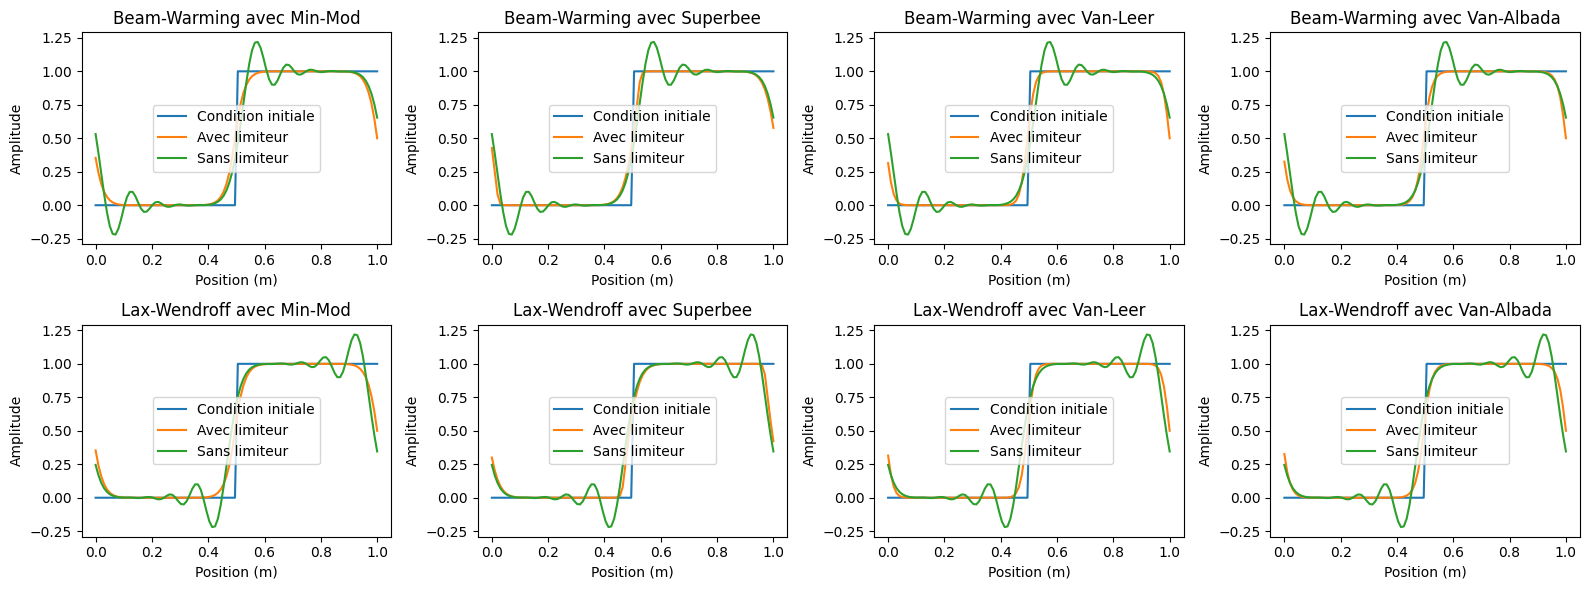

In [18]:
# Afficher les discrétisations
def affichage_discretisation():
    
    # Boucle sur les différents limiteurs
    limiters = [minmod, superbee, van_leer, van_albada]
    labels = ['Min-Mod', 'Superbee', 'Van-Leer', 'Van-Albada']
    
    plt.figure(figsize=(4*len(limiters), 6))
    
    # Boucle sur les différentes limiteurs
    for i, limiter in enumerate(limiters):
        dx = L / m  # Pas d'espace
        dt = C * dx  # Pas de temps en fonction de la CFL

        # Initialisation de la condition initiale
        x = np.linspace(0, L, m)
        u_beam_limit = condition_init(x, x0)
        u_lax_limit = condition_init(x, x0)
        u_beam = np.copy(u_beam_limit)
        u_lax = np.copy(u_lax_limit)

        # Boucle temporelle
        for n in range(int(T / dt) - 1):

            # Discrétisation par le schéma de Beam-Warming avec et sans limiteur
            u_beam_limit = beam_warming(u_beam_limit, C, limiter)
            u_beam = beam_warming(u_beam, C, identity)
            
            # Discrétisation par le schéma de Lax-Wendroff avec et sans limiteur
            u_lax_limit = lax_wendroff(u_lax_limit, C, limiter)
            u_lax = lax_wendroff(u_lax, C, identity)
           
        # Affichage des résultats
        plt.subplot(2, len(limiters), i % len(limiters) + 1) 
        plt.title(f"Beam-Warming avec {labels[i]}")
        plt.plot(x, condition_init(x, x0), label="Condition initiale")
        plt.plot(x, u_beam_limit, label="Avec limiteur")
        plt.plot(x, u_beam, label="Sans limiteur")        
        plt.xlabel('Position (m)')
        plt.ylabel('Amplitude')
        plt.legend()

        plt.subplot(2, len(limiters), i % len(limiters) + 1 + len(limiters))
        plt.title(f"Lax-Wendroff avec {labels[i]}")
        plt.plot(x, condition_init(x, x0), label="Condition initiale")
        plt.plot(x, u_lax_limit, label="Avec limiteur")
        plt.plot(x, u_lax, label="Sans limiteur")
        plt.xlabel('Position (m)')
        plt.ylabel('Amplitude')
        plt.legend()

    plt.tight_layout()   
    plt.show()
    
affichage_discretisation()

2. Tracer l’évolution temporelle de la variation totale $TV$ , définie comme :
$$
TV(u^n) = \sum_{i=1}^{m}|u_{i+1}^{n} - u_{i}^{n}|
$$

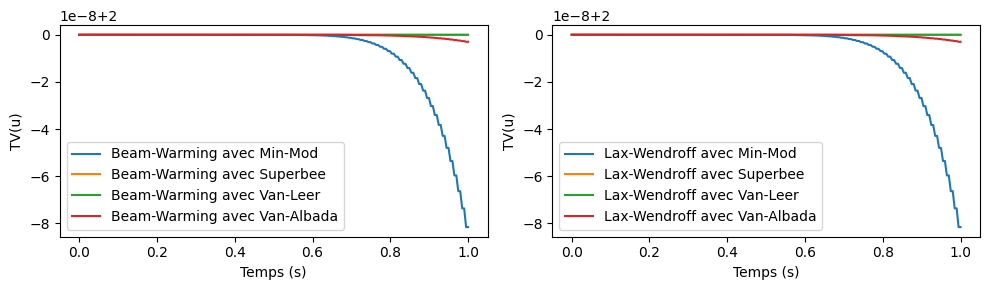

In [14]:
def evolution_temporelle():
    
    # Boucle sur les différents limiteurs
    limiters = [minmod, superbee, van_leer, van_albada]
    labels = ['Min-Mod', 'Superbee', 'Van-Leer', 'Van-Albada']
    
    plt.figure(figsize=(10, 3))
    
    # Boucle sur les différentes limiteurs
    for i, limiter in enumerate(limiters):
        dx = L / m  # Pas d'espace
        dt = C * dx  # Pas de temps en fonction de la CFL

        # Initialisation de la condition initiale
        x = np.linspace(0, L, m)
        u_beam_limit = condition_init(x, x0)
        u_lax_limit = condition_init(x, x0)
        
        T_scale = np.linspace(0, T, int(T / dt))
        TV_u_beam_limit = [np.sum(np.abs(np.roll(u_beam_limit, -1) - u_beam_limit))]
        TV_u_lax_limit = [np.sum(np.abs(np.roll(u_lax_limit, -1) - u_lax_limit))]

        # Boucle temporelle
        for n in range(int(T / dt) - 1):

            # Discrétisation par le schéma de Beam-Warming avec limiteur
            u_beam_limit = beam_warming(u_beam_limit, C, limiter)
            TV_u_beam_limit.append(np.sum(np.abs(np.roll(u_beam_limit, -1) - u_beam_limit)))
            
            # Discrétisation par le schéma de Lax-Wendroff avec limiteur
            u_lax_limit = lax_wendroff(u_lax_limit, C, limiter)
            TV_u_lax_limit.append(np.sum(np.abs(np.roll(u_lax_limit, -1) - u_lax_limit)))
        
        plt.subplot(1, 2, 1)
        plt.plot(T_scale, TV_u_beam_limit, label=f"Beam-Warming avec {labels[i]}")
        plt.xlabel('Temps (s)')
        plt.ylabel('TV(u)')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(T_scale, TV_u_lax_limit, label=f"Lax-Wendroff avec {labels[i]}")
        plt.xlabel('Temps (s)')
        plt.ylabel('TV(u)')
        plt.legend()
    
    plt.tight_layout()   
    plt.show()
    
evolution_temporelle()

3. Commenter l’ensemble des résultats obtenus.